In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from tqdm import tqdm

from thirdparty.fem_2d_rec import fem_poisson_solver,mesh_fem_2d_rec,get_matrices_2d
from common.util import create_boundary_mask, create_interior_mask, Dirichlet_bc_tensor, Dirichlet_bc_array, he_weights_init
from models.autoencoder import Autoencoder
from loss.loss import unsupervised_loss, h_loss

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
f_values = np.arange(-5000, 5000, 2)
np.savetxt('./f_constant.txt', f_values, fmt='%f')
print("Create f_constant.txt.")

Create f_constant.txt.


In [4]:
f_values = np.loadtxt('./f_constant.txt')
print(f"Loaded {len(f_values)} f function.")

Loaded 5000 f function.


In [5]:
input_shape = (256, 256)
f_matrices = np.array([np.full(input_shape, f_value) for f_value in f_values])
print(f"{len(f_matrices)} f matrices")

5000 f matrices


In [6]:
class PoissonDataset(Dataset):
    def __init__(self, f_matrices):
        self.f_matrices = f_matrices

    def __len__(self):
        return len(self.f_matrices)

    def __getitem__(self, idx):
        f_matrix = self.f_matrices[idx]
        f_tensor = torch.tensor(f_matrix).unsqueeze(0).float()  # (1, H, W) 형태로 변환
        return f_tensor

In [7]:
dataset = PoissonDataset(f_matrices)
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)

In [8]:
a = 0
b = 1
k = 1
M = 255
h = 1 / M

In [9]:
def unsupervised_loss(u_pred, f, h, interior_mask, boundary_mask):
    laplacian_filter = torch.tensor([[0, -1, 0], [-1, 4, -1], [0, -1, 0]], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(u_pred.device) # (1, 1, H, W) 형태로 변환 / 마이너스 라플라시안 필터
    laplacian_u = torch.nn.functional.conv2d(u_pred, laplacian_filter, padding=1)

    interior_loss = torch.sum((f * h**2 - laplacian_u) ** 2)
    # boundary_loss = torch.sum((u_pred * boundary_mask) ** 2)

    return interior_loss

In [10]:
class Autoencoder(nn.Module):
    def __init__(self, rep_dim=128):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Flatten(),
            nn.Linear(128 * 32 * 32, rep_dim),
            nn.LeakyReLU(negative_slope=0.01)
        )

        # Latent space
        self.fc = nn.Linear(rep_dim, rep_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(rep_dim, 128 * 32 * 32),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Unflatten(1, (128, 32, 32)),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.01),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.Tanh(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        latent = self.fc(encoded)
        u_pred = self.decoder(latent)
        return u_pred, latent

In [11]:
def he_weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.kaiming_normal_(m.weight, a=0.01)  # He 초기화 사용
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, a=0.01)  # He 초기화 사용
        nn.init.constant_(m.bias, 0)

/home/fned/anaconda3/envs/pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  1%|          | 1/100 [00:07<11:59,  7.27s/it]

Epoch [1/100], Loss: 163648.7385203125


  2%|▏         | 2/100 [00:13<10:27,  6.40s/it]

Epoch [2/100], Loss: 12080.60616875


  3%|▎         | 3/100 [00:18<09:55,  6.14s/it]

Epoch [3/100], Loss: 5126.231202539063


  4%|▍         | 4/100 [00:24<09:33,  5.97s/it]

Epoch [4/100], Loss: 4358.7617765625


  5%|▌         | 5/100 [00:30<09:20,  5.90s/it]

Epoch [5/100], Loss: 2459.7533733398436


  6%|▌         | 6/100 [00:36<09:07,  5.83s/it]

Epoch [6/100], Loss: 1902.7831015625


  7%|▋         | 7/100 [00:41<09:00,  5.82s/it]

Epoch [7/100], Loss: 1595.3803765625


  8%|▊         | 8/100 [00:47<08:52,  5.79s/it]

Epoch [8/100], Loss: 1378.630897998047


  9%|▉         | 9/100 [00:53<08:48,  5.80s/it]

Epoch [9/100], Loss: 1316.310744189453


 10%|█         | 10/100 [00:59<08:42,  5.80s/it]

Epoch [10/100], Loss: 1224.6921836914062


 11%|█         | 11/100 [01:05<08:37,  5.82s/it]

Epoch [11/100], Loss: 1340.6059036132813


 12%|█▏        | 12/100 [01:10<08:31,  5.82s/it]

Epoch [12/100], Loss: 1307.100362890625


 13%|█▎        | 13/100 [01:16<08:25,  5.81s/it]

Epoch [13/100], Loss: 1170.7954416992188


 14%|█▍        | 14/100 [01:22<08:17,  5.78s/it]

Epoch [14/100], Loss: 1133.8096113769532


 15%|█▌        | 15/100 [01:28<08:11,  5.78s/it]

Epoch [15/100], Loss: 1136.2386482421875


 16%|█▌        | 16/100 [01:33<08:03,  5.75s/it]

Epoch [16/100], Loss: 1096.9930485839843


 17%|█▋        | 17/100 [01:39<07:56,  5.74s/it]

Epoch [17/100], Loss: 1088.9221931640625


 18%|█▊        | 18/100 [01:45<07:51,  5.75s/it]

Epoch [18/100], Loss: 1112.8699075195314


 19%|█▉        | 19/100 [01:51<07:45,  5.75s/it]

Epoch [19/100], Loss: 1066.37767734375


 20%|██        | 20/100 [01:56<07:42,  5.78s/it]

Epoch [20/100], Loss: 1073.445890234375


 21%|██        | 21/100 [02:02<07:35,  5.76s/it]

Epoch [21/100], Loss: 1068.7874486572266


 22%|██▏       | 22/100 [02:08<07:32,  5.80s/it]

Epoch [22/100], Loss: 1070.9314280761719


 23%|██▎       | 23/100 [02:14<07:26,  5.80s/it]

Epoch [23/100], Loss: 1085.6405201049804


 24%|██▍       | 24/100 [02:20<07:21,  5.81s/it]

Epoch [24/100], Loss: 1044.5628759765625


 25%|██▌       | 25/100 [02:26<07:15,  5.80s/it]

Epoch [25/100], Loss: 1075.219096142578


 26%|██▌       | 26/100 [02:31<07:10,  5.82s/it]

Epoch [26/100], Loss: 1080.0787172363282


 27%|██▋       | 27/100 [02:37<07:03,  5.80s/it]

Epoch [27/100], Loss: 1044.2244200439452


 28%|██▊       | 28/100 [02:43<06:57,  5.80s/it]

Epoch [28/100], Loss: 1120.5095568847655


 29%|██▉       | 29/100 [02:49<06:50,  5.78s/it]

Epoch [29/100], Loss: 1040.951606225586


 30%|███       | 30/100 [02:54<06:44,  5.78s/it]

Epoch [30/100], Loss: 1038.9355182617187


 31%|███       | 31/100 [03:00<06:37,  5.76s/it]

Epoch [31/100], Loss: 1048.9414228515625


 32%|███▏      | 32/100 [03:06<06:37,  5.84s/it]

Epoch [32/100], Loss: 1036.0018384765624


 33%|███▎      | 33/100 [03:12<06:29,  5.81s/it]

Epoch [33/100], Loss: 1044.3439624511718


 34%|███▍      | 34/100 [03:18<06:24,  5.83s/it]

Epoch [34/100], Loss: 1036.8379755615235


 35%|███▌      | 35/100 [03:24<06:24,  5.92s/it]

Epoch [35/100], Loss: 1129.1020098632812


 36%|███▌      | 36/100 [03:30<06:16,  5.89s/it]

Epoch [36/100], Loss: 1037.8123097167968


 37%|███▋      | 37/100 [03:36<06:09,  5.87s/it]

Epoch [37/100], Loss: 1037.1072170410157


 38%|███▊      | 38/100 [03:41<06:03,  5.86s/it]

Epoch [38/100], Loss: 1035.6413076416015


 39%|███▉      | 39/100 [03:47<05:55,  5.82s/it]

Epoch [39/100], Loss: 1035.1950518188476


 40%|████      | 40/100 [03:53<05:49,  5.82s/it]

Epoch [40/100], Loss: 1038.5922736328125


 41%|████      | 41/100 [03:59<05:42,  5.80s/it]

Epoch [41/100], Loss: 1033.713566796875


 42%|████▏     | 42/100 [04:05<05:37,  5.81s/it]

Epoch [42/100], Loss: 1024.9066013427735


 43%|████▎     | 43/100 [04:10<05:30,  5.80s/it]

Epoch [43/100], Loss: 1002.3094583984375


 44%|████▍     | 44/100 [04:16<05:27,  5.84s/it]

Epoch [44/100], Loss: 995.9083249267578


 45%|████▌     | 45/100 [04:22<05:21,  5.84s/it]

Epoch [45/100], Loss: 990.4674801757812


 46%|████▌     | 46/100 [04:28<05:17,  5.88s/it]

Epoch [46/100], Loss: 986.7603216796875


 47%|████▋     | 47/100 [04:34<05:10,  5.87s/it]

Epoch [47/100], Loss: 982.6383338378906


 48%|████▊     | 48/100 [04:40<05:05,  5.88s/it]

Epoch [48/100], Loss: 977.327419140625


 49%|████▉     | 49/100 [04:46<04:59,  5.88s/it]

Epoch [49/100], Loss: 977.6296546386719


 50%|█████     | 50/100 [04:52<04:55,  5.91s/it]

Epoch [50/100], Loss: 966.2570624023438


 51%|█████     | 51/100 [04:58<04:48,  5.89s/it]

Epoch [51/100], Loss: 958.7825202636719


 52%|█████▏    | 52/100 [05:03<04:42,  5.88s/it]

Epoch [52/100], Loss: 949.7226381347656


 53%|█████▎    | 53/100 [05:09<04:33,  5.81s/it]

Epoch [53/100], Loss: 945.0570130859375


 54%|█████▍    | 54/100 [05:15<04:27,  5.82s/it]

Epoch [54/100], Loss: 937.2367265136719


 55%|█████▌    | 55/100 [05:21<04:20,  5.78s/it]

Epoch [55/100], Loss: 935.9668440673828


 56%|█████▌    | 56/100 [05:26<04:14,  5.79s/it]

Epoch [56/100], Loss: 927.680448046875


 57%|█████▋    | 57/100 [05:32<04:08,  5.78s/it]

Epoch [57/100], Loss: 924.1983008056641


 58%|█████▊    | 58/100 [05:38<04:02,  5.78s/it]

Epoch [58/100], Loss: 920.0517351074219


 59%|█████▉    | 59/100 [05:44<03:55,  5.74s/it]

Epoch [59/100], Loss: 916.9445478759766


 60%|██████    | 60/100 [05:49<03:50,  5.75s/it]

Epoch [60/100], Loss: 914.418222680664


 61%|██████    | 61/100 [05:55<03:43,  5.73s/it]

Epoch [61/100], Loss: 911.2689934570312


 62%|██████▏   | 62/100 [06:01<03:38,  5.74s/it]

Epoch [62/100], Loss: 908.198460131836


 63%|██████▎   | 63/100 [06:06<03:31,  5.73s/it]

Epoch [63/100], Loss: 906.5508923583984


 64%|██████▍   | 64/100 [06:12<03:26,  5.73s/it]

Epoch [64/100], Loss: 904.3271487792969


 65%|██████▌   | 65/100 [06:18<03:19,  5.71s/it]

Epoch [65/100], Loss: 901.0840715332031


 66%|██████▌   | 66/100 [06:24<03:15,  5.75s/it]

Epoch [66/100], Loss: 901.8190355957031


 67%|██████▋   | 67/100 [06:29<03:08,  5.71s/it]

Epoch [67/100], Loss: 897.3615095458985


 68%|██████▊   | 68/100 [06:35<03:02,  5.71s/it]

Epoch [68/100], Loss: 895.4456655517578


 69%|██████▉   | 69/100 [06:41<02:56,  5.70s/it]

Epoch [69/100], Loss: 893.7606931152344


 70%|███████   | 70/100 [06:46<02:51,  5.71s/it]

Epoch [70/100], Loss: 892.6604537109375


 71%|███████   | 71/100 [06:52<02:44,  5.68s/it]

Epoch [71/100], Loss: 890.3353889648438


 72%|███████▏  | 72/100 [06:58<02:39,  5.70s/it]

Epoch [72/100], Loss: 889.9646885498047


 73%|███████▎  | 73/100 [07:03<02:33,  5.69s/it]

Epoch [73/100], Loss: 886.8649919921875


 74%|███████▍  | 74/100 [07:09<02:29,  5.73s/it]

Epoch [74/100], Loss: 887.0235386230469


 75%|███████▌  | 75/100 [07:15<02:25,  5.80s/it]

Epoch [75/100], Loss: 883.7990348876953


 76%|███████▌  | 76/100 [07:21<02:19,  5.82s/it]

Epoch [76/100], Loss: 885.1053069091797


 77%|███████▋  | 77/100 [07:27<02:13,  5.81s/it]

Epoch [77/100], Loss: 883.4533624023437


 78%|███████▊  | 78/100 [07:33<02:08,  5.83s/it]

Epoch [78/100], Loss: 880.8631140136719


 79%|███████▉  | 79/100 [07:39<02:03,  5.86s/it]

Epoch [79/100], Loss: 879.4741932617187


 80%|████████  | 80/100 [07:45<01:57,  5.88s/it]

Epoch [80/100], Loss: 878.9616423583984


 81%|████████  | 81/100 [07:51<01:51,  5.89s/it]

Epoch [81/100], Loss: 876.1431525878907


 82%|████████▏ | 82/100 [07:56<01:45,  5.89s/it]

Epoch [82/100], Loss: 877.2491690185547


 83%|████████▎ | 83/100 [08:02<01:40,  5.89s/it]

Epoch [83/100], Loss: 887.626955078125


 84%|████████▍ | 84/100 [08:08<01:34,  5.93s/it]

Epoch [84/100], Loss: 873.6353483886719


 85%|████████▌ | 85/100 [08:14<01:28,  5.89s/it]

Epoch [85/100], Loss: 873.5709700927735


 86%|████████▌ | 86/100 [08:20<01:22,  5.86s/it]

Epoch [86/100], Loss: 872.1323642578125


 87%|████████▋ | 87/100 [08:26<01:15,  5.82s/it]

Epoch [87/100], Loss: 870.656790234375


 88%|████████▊ | 88/100 [08:31<01:09,  5.81s/it]

Epoch [88/100], Loss: 869.868972265625


 89%|████████▉ | 89/100 [08:37<01:03,  5.79s/it]

Epoch [89/100], Loss: 867.9510529541016


 90%|█████████ | 90/100 [08:43<00:58,  5.82s/it]

Epoch [90/100], Loss: 868.5512169921875


 91%|█████████ | 91/100 [08:49<00:52,  5.81s/it]

Epoch [91/100], Loss: 868.092448071289


 92%|█████████▏| 92/100 [08:55<00:46,  5.79s/it]

Epoch [92/100], Loss: 865.7302754394532


 93%|█████████▎| 93/100 [09:00<00:40,  5.77s/it]

Epoch [93/100], Loss: 866.1885353027344


 94%|█████████▍| 94/100 [09:06<00:34,  5.77s/it]

Epoch [94/100], Loss: 865.4423907226562


 95%|█████████▌| 95/100 [09:12<00:28,  5.76s/it]

Epoch [95/100], Loss: 863.2028862060547


 96%|█████████▌| 96/100 [09:18<00:23,  5.80s/it]

Epoch [96/100], Loss: 862.2283141113281


 97%|█████████▋| 97/100 [09:23<00:17,  5.79s/it]

Epoch [97/100], Loss: 861.0901494506836


 98%|█████████▊| 98/100 [09:29<00:11,  5.79s/it]

Epoch [98/100], Loss: 861.6244928710937


 99%|█████████▉| 99/100 [09:35<00:05,  5.77s/it]

Epoch [99/100], Loss: 860.0178712890626


100%|██████████| 100/100 [09:41<00:00,  5.81s/it]

Epoch [100/100], Loss: 861.1576626708984


Last Loss: 861.1577 Last model saved to last_autoencoder_model.pth
Best Loss: 860.0179 Best model saved to best_autoencoder_model.pth
Best model found at epoch 99


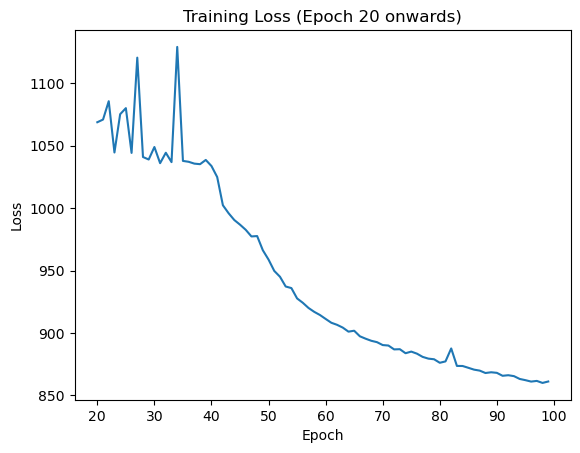

In [12]:
model = Autoencoder()
# model.apply(he_weights_init)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
model = model.to(device)

boundary_mask = create_boundary_mask((256, 256)).to(device)
interior_mask = create_interior_mask((256, 256)).to(device)

num_epochs = 100
patience = 10
best_loss = float('inf')
best_epoch = 0
train_losses = []
early_stopping_counter = 0

for epoch in tqdm(range(num_epochs)):
    model.train()
    train_loss = 0
    for data in train_loader:
        inputs = data
        inputs = inputs.to(device)
        optimizer.zero_grad()
        u_pred, _ = model(inputs)
        loss = unsupervised_loss(u_pred, inputs, h, interior_mask, boundary_mask)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss}')
    
    if train_loss < best_loss:
        best_loss = train_loss
        best_model_wts = model.state_dict()
        early_stopping_counter = 0
        best_epoch = epoch
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

torch.save(model.state_dict(), 'last_autoencoder_model.pth')
torch.save(best_model_wts, 'best_autoencoder_model.pth')

print(f'Last Loss: {train_loss:.4f} Last model saved to last_autoencoder_model.pth')
print(f'Best Loss: {best_loss:.4f} Best model saved to best_autoencoder_model.pth')
print(f'Best model found at epoch {best_epoch+1}')

plt.plot(range(20, len(train_losses)), train_losses[20:])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss (Epoch 20 onwards)')
plt.show()

In [13]:
model.load_state_dict(torch.load('best_autoencoder_model.pth'))
model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=131072, out_features=128, bias=True)
    (11): LeakyReLU(negative_slope=0.01)
  )
  (fc): Linear(in_features=128, out_features=128, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=131072, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (

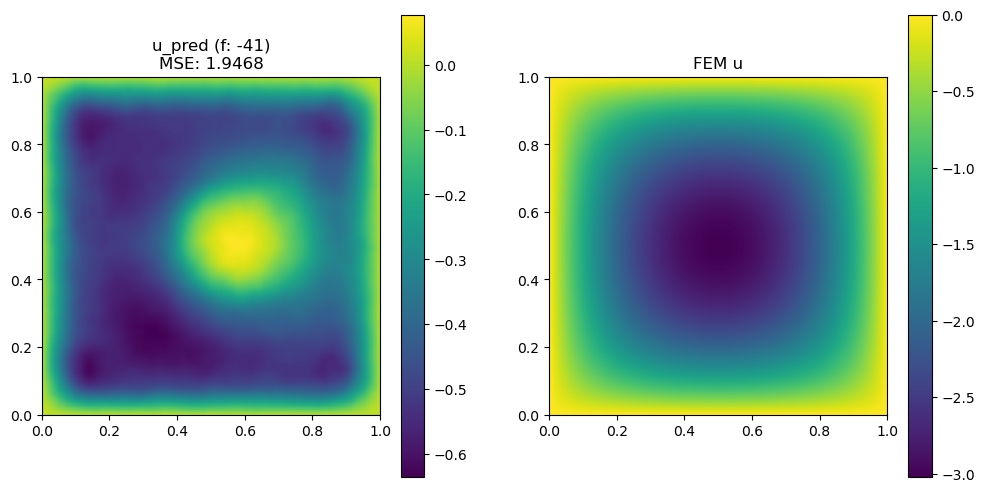

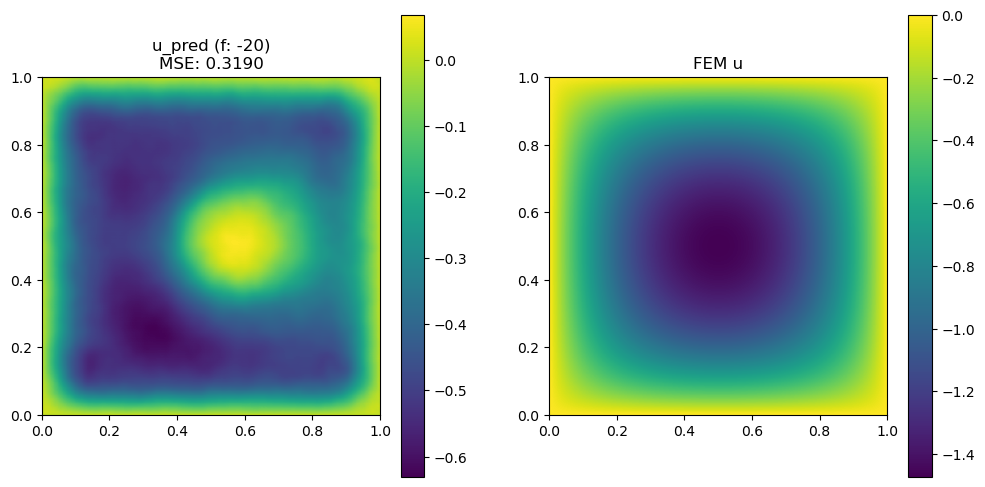

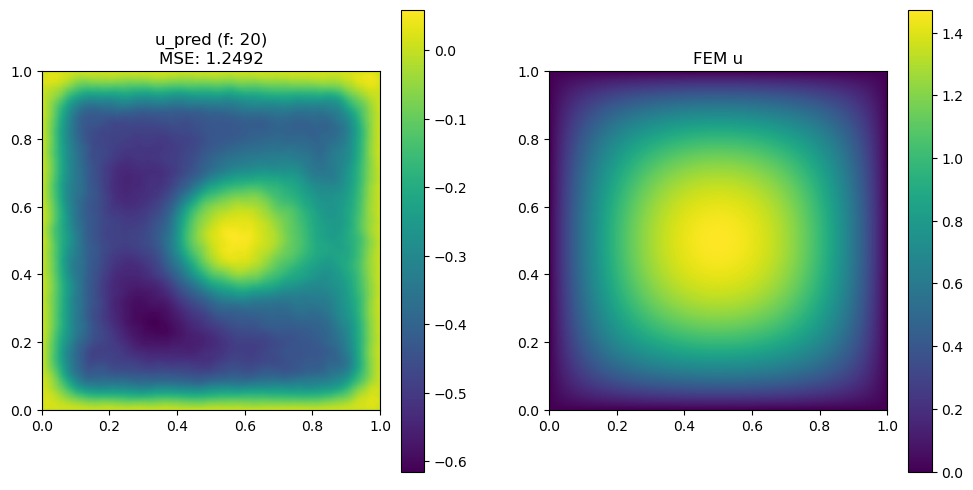

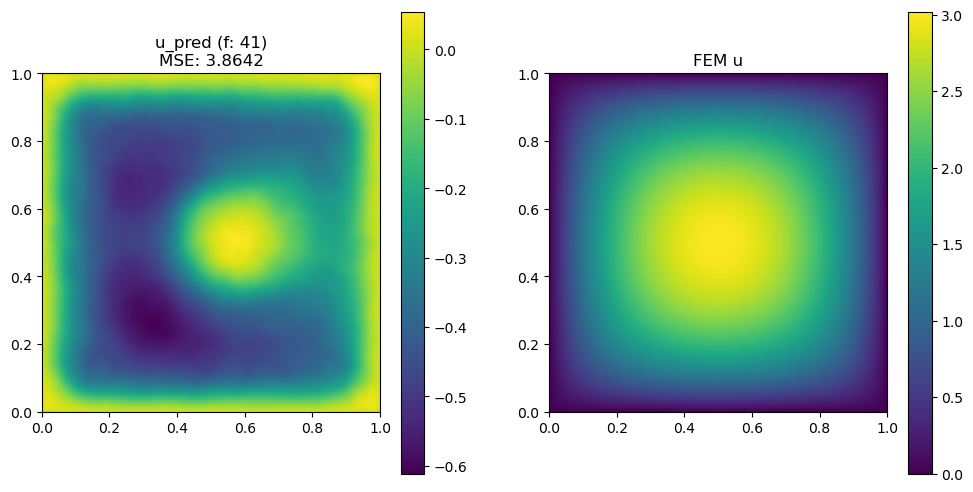

In [14]:
test_f_values = [-41, -20, 20, 41]
c4n, n4e, n4db, ind4e = mesh_fem_2d_rec(a, b, a, b, M, M, k)
M_R, Srr_R, Sss_R, Dr_R, Ds_R = get_matrices_2d(k)

for test_f_value in test_f_values:
    new_f = np.full((256, 256), test_f_value)
    f_tensor = torch.tensor(new_f).unsqueeze(0).unsqueeze(0).float().to(device)

    with torch.no_grad():
        predicted_u, _ = model(f_tensor)

    predicted_u = Dirichlet_bc_array(predicted_u.squeeze().cpu().numpy())

    f = lambda x: np.full(x.shape[0], test_f_value)
    u_D = lambda x: x[:,0] * 0

    fem_u = fem_poisson_solver(c4n, n4e, n4db, ind4e, k, M_R, Srr_R, Sss_R, f, u_D)
    fem_u_reshaped = fem_u.reshape((256, 256))
    
    mse = np.mean((predicted_u - fem_u_reshaped) ** 2)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title(f"u_pred (f: {test_f_value})\nMSE: {mse:.4f}")
    plt.imshow(predicted_u, cmap='viridis', extent=(0, 1, 0, 1))
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.title(f"FEM u")
    plt.imshow(fem_u_reshaped, cmap='viridis', extent=(0, 1, 0, 1))
    plt.colorbar()

    plt.show()

In [15]:
test_f_values = [-200, -20, 5, 20, 200]
c4n, n4e, n4db, ind4e = mesh_fem_2d_rec(a, b, a, b, M, M, k)
M_R, Srr_R, Sss_R, Dr_R, Ds_R = get_matrices_2d(k)

for test_f_value in test_f_values:
    new_f = np.full((256, 256), test_f_value)
    f_tensor = torch.tensor(new_f).unsqueeze(0).unsqueeze(0).float().to(device)

    with torch.no_grad():
        predicted_u, _ = model(f_tensor)

    predicted_u = Dirichlet_bc_array(predicted_u.squeeze().cpu().numpy())

    f = lambda x: np.full(x.shape[0], test_f_value)
    u_D = lambda x: x[:,0] * 0

    fem_u = fem_poisson_solver(c4n, n4e, n4db, ind4e, k, M_R, Srr_R, Sss_R, f, u_D)
    fem_u_reshaped = fem_u.reshape((256, 256))
    
    mse = np.mean((predicted_u - fem_u_reshaped) ** 2)
    print(f'Mean Squared Error: {mse}\n')
    print(f'Predicted u: \n{predicted_u}\n')
    print(f'FEM u: \n{fem_u_reshaped}\n')

Mean Squared Error: 61.78813387101979

Predicted u: 
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.00562081 -0.01562305 ... -0.02094647 -0.00866351
   0.        ]
 [ 0.         -0.01625196 -0.0303545  ... -0.0349479  -0.02092355
   0.        ]
 ...
 [ 0.         -0.01381185 -0.02591829 ... -0.03871909 -0.02902456
   0.        ]
 [ 0.         -0.00546333 -0.01390754 ... -0.0277618  -0.01941346
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]

FEM u: 
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.0104596  -0.01917227 ... -0.01917227 -0.0104596
   0.        ]
 [ 0.         -0.01917227 -0.03610501 ... -0.03610501 -0.01917227
   0.        ]
 ...
 [ 0.         -0.01917227 -0.03610501 ... -0.03610501 -0.01917227
   0.        ]
 [ 0.         -0.0104596  -0.01917227 ... -0.01917227 -0.0104596
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0